<a href="https://colab.research.google.com/github/Plashka320/-/blob/main/%D0%A1%D0%B5%D0%BC%D0%B8%D0%BD%D0%B0%D1%80_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Оглавление
1. [Решающее дерево](#section1)   
2. [Бэггинг над решающими деревьями](#section2)    
3. [Бустинг над решающими деревьями](#section3)   
3. [Бустинг vs Random Forest](#section4)   
5. [Bias-variance trade-off на практике](#section5)   

# 1. Решающее дерево <a name="section1"></a>

In [ ]:
! pip install pydotplus GraphViz -q

In [ ]:
import pydotplus
import pandas as pd
import numpy as np

from IPython.display import Image
from sklearn import tree
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
!wget https://raw.githubusercontent.com/data-mining-in-action/DMIA_Base_2019_Spring/master/seminar0405/HR.csv

--2024-08-23 15:24:33--  https://raw.githubusercontent.com/data-mining-in-action/DMIA_Base_2019_Spring/master/seminar0405/HR.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 283562 (277K) [text/plain]
Saving to: ‘HR.csv’

HR.csv              100%[===================>] 276.92K  --.-KB/s    in 0.04s   

2024-08-23 15:24:34 (7.03 MB/s) - ‘HR.csv’ saved [283562/283562]



https://www.kaggle.com/ludobenistant/hr-analytics-1/data

This dataset is simulated

Why are our best and most experienced employees leaving prematurely? Have fun with this database and try to predict which valuable employees will leave next. Fields in the dataset include:

Last evaluation:
Number of projects
Average monthly hours
Time spent at the company
Whether they have had a work accident
Whether they have had a promotion in the last 5 years
Whether the employee has left

In [ ]:
data = pd.read_csv('HR.csv')
data[:5]

,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
0,0.53,2,157,3,0,1,0
1,0.86,5,262,6,0,0,0
2,0.88,7,272,4,0,1,0
3,0.87,5,223,5,0,1,0
4,0.52,2,159,3,0,1,0


In [ ]:
target = 'left'
features = [c for c in data if c != target]
print(features)

['last_evaluation', 'number_project', 'average_montly_hours', 'time_spend_company', 'Work_accident', 'promotion_last_5years']


## Строим дерево с помощью sklearn

In [ ]:
model = tree.DecisionTreeClassifier()
_ = model.fit(data[features], data[target])

**Основные параметры**
*   max_depth – глубина дерева
*   max_features – количество признаков, участвующих при выборе сплита в вершине дерева



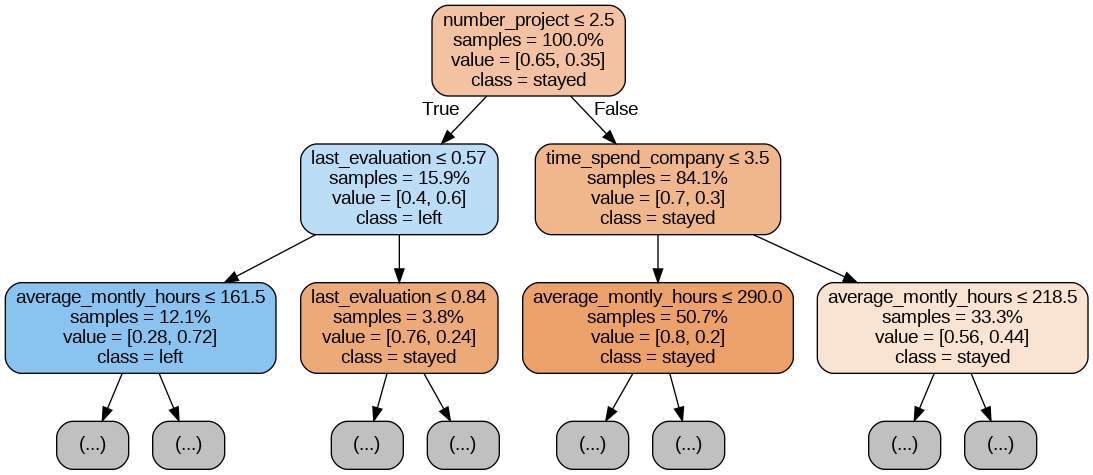

In [ ]:
class_names = ['stayed', 'left']

def plot_tree(model, out_file, max_depth):

    dot_data = tree.export_graphviz(decision_tree=model, out_file=out_file,
                                    max_depth=max_depth,
                                    feature_names=features,
                                    class_names=class_names,
                                    filled=True, rounded=True,
                                    special_characters=True,
                                    proportion = True, precision=2,
                                    label='all', impurity=False,
                                   )
    with open(out_file) as f:
      s = f.read()
      s = s.replace("\n", "")
      f.close()
    graph = pydotplus.graph_from_dot_data(s.replace("\n", ""))
    return Image(graph.create_png())

plot_tree(model, out_file="small_tree.out", max_depth=2)

## Оценим качество

In [ ]:
train_data, test_data, train_target, test_target = (
    train_test_split(data[features], data[target], test_size = 0.5, random_state=0))

In [ ]:
_ = model.fit(train_data, train_target)

In [ ]:
test_predictions = model.predict(test_data)
print(test_predictions[:50])

[0 0 0 1 0 0 0 0 0 1 0 0 1 1 0 0 1 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1 0 0 1 0 0
 0 1 0 0 0 0 0 1 0 1 0 1 1]


In [ ]:
print(accuracy_score(test_target, test_predictions))

0.6629333333333334


In [ ]:
train_predictions = model.predict(train_data)

In [ ]:
print(accuracy_score(train_target, train_predictions))

0.9541272169622617


## Почему качество на тесте и трейне так отличается?

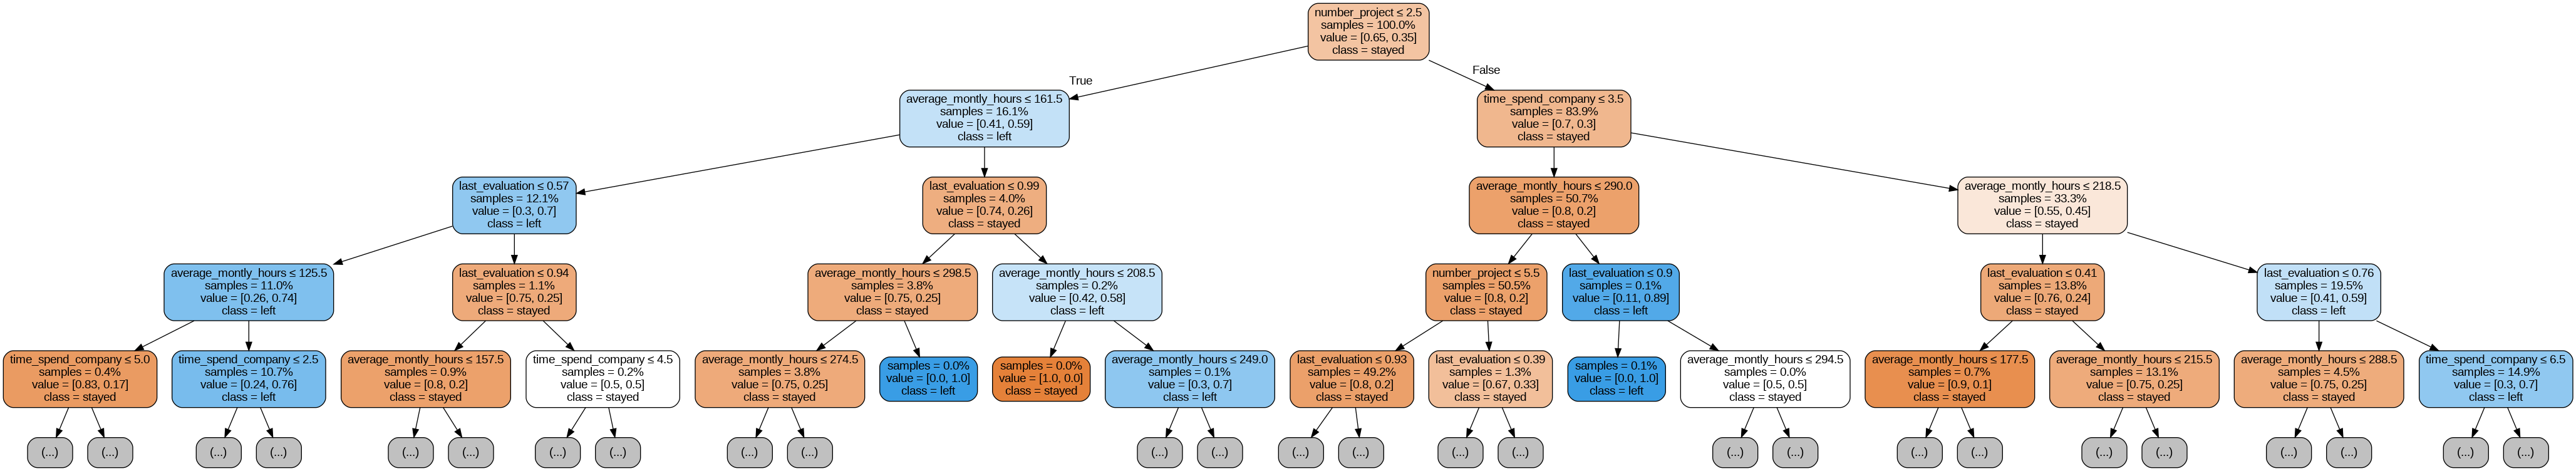

In [ ]:
plot_tree(model, out_file='tree.out', max_depth=4)

## Исследуем "устойчивость" модели

##### Устойчивость к выбросам в target

In [ ]:
def plot_noised_tree(noise_size):
    np.random.seed(42)
    model.fit(
        train_data,
        [ np.random.choice([0, 1]) for _ in range(noise_size)] + list(train_target[noise_size:])
    )
    return plot_tree(model, "first_tree.out", max_depth=3)

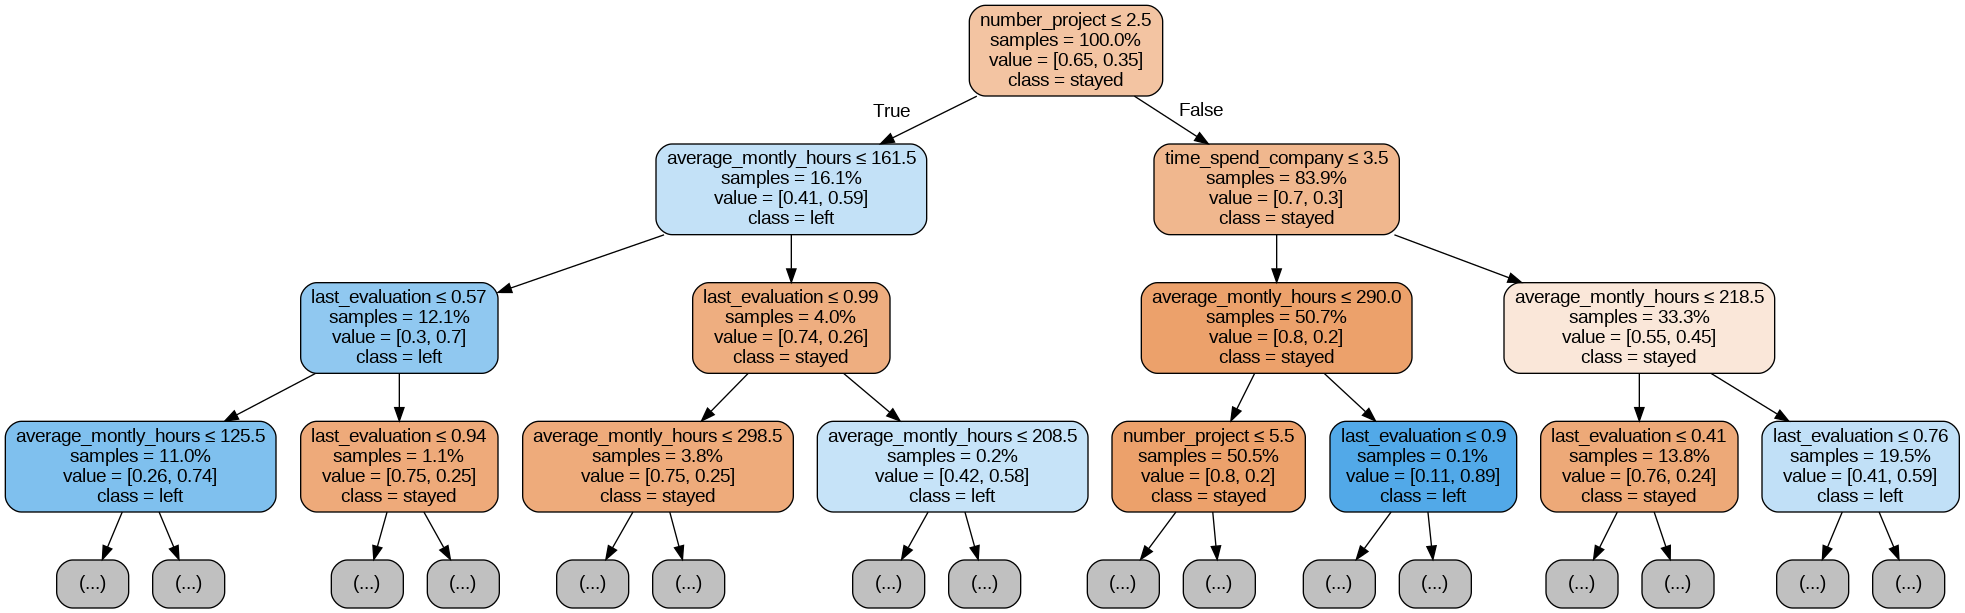

In [ ]:
plot_noised_tree(0)

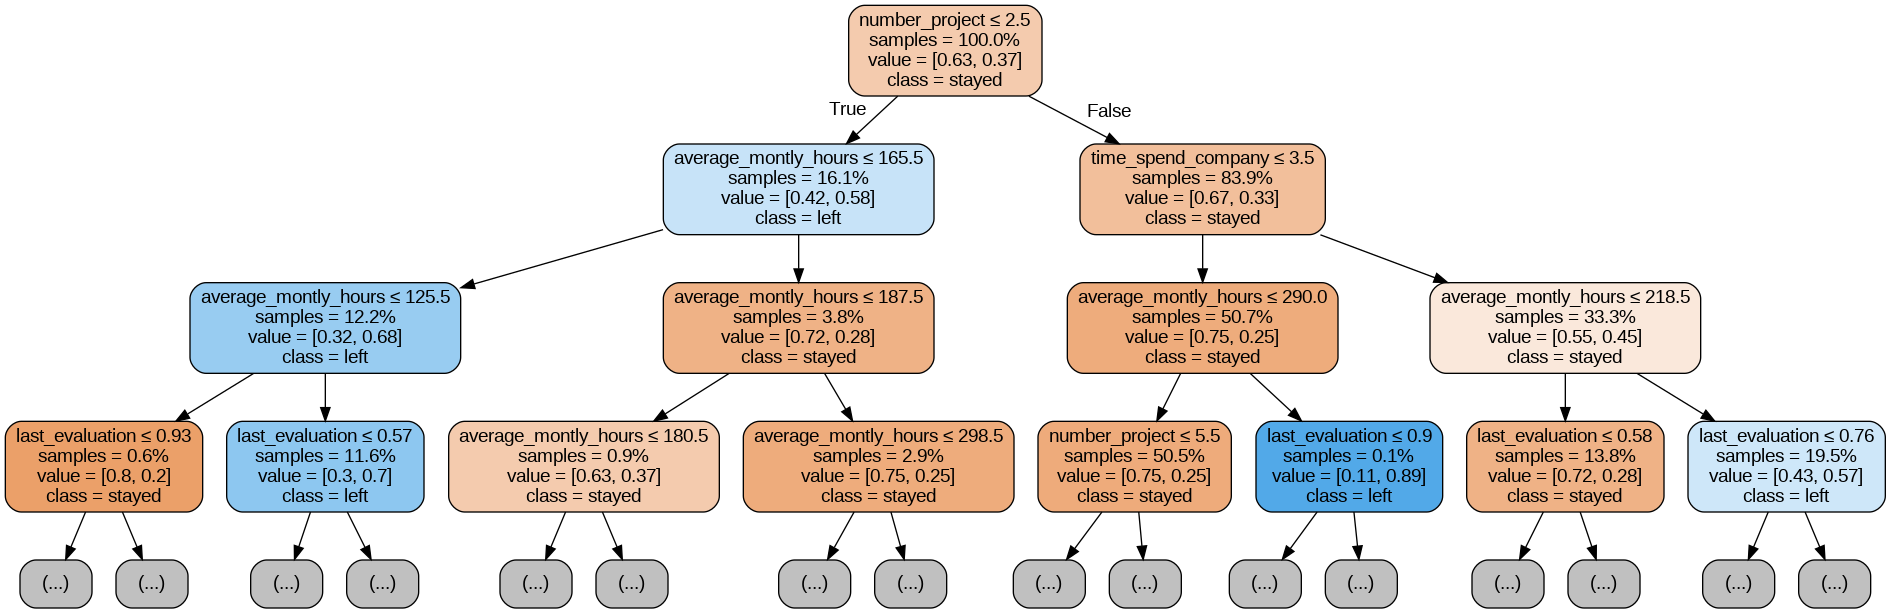

In [ ]:
plot_noised_tree(1000)

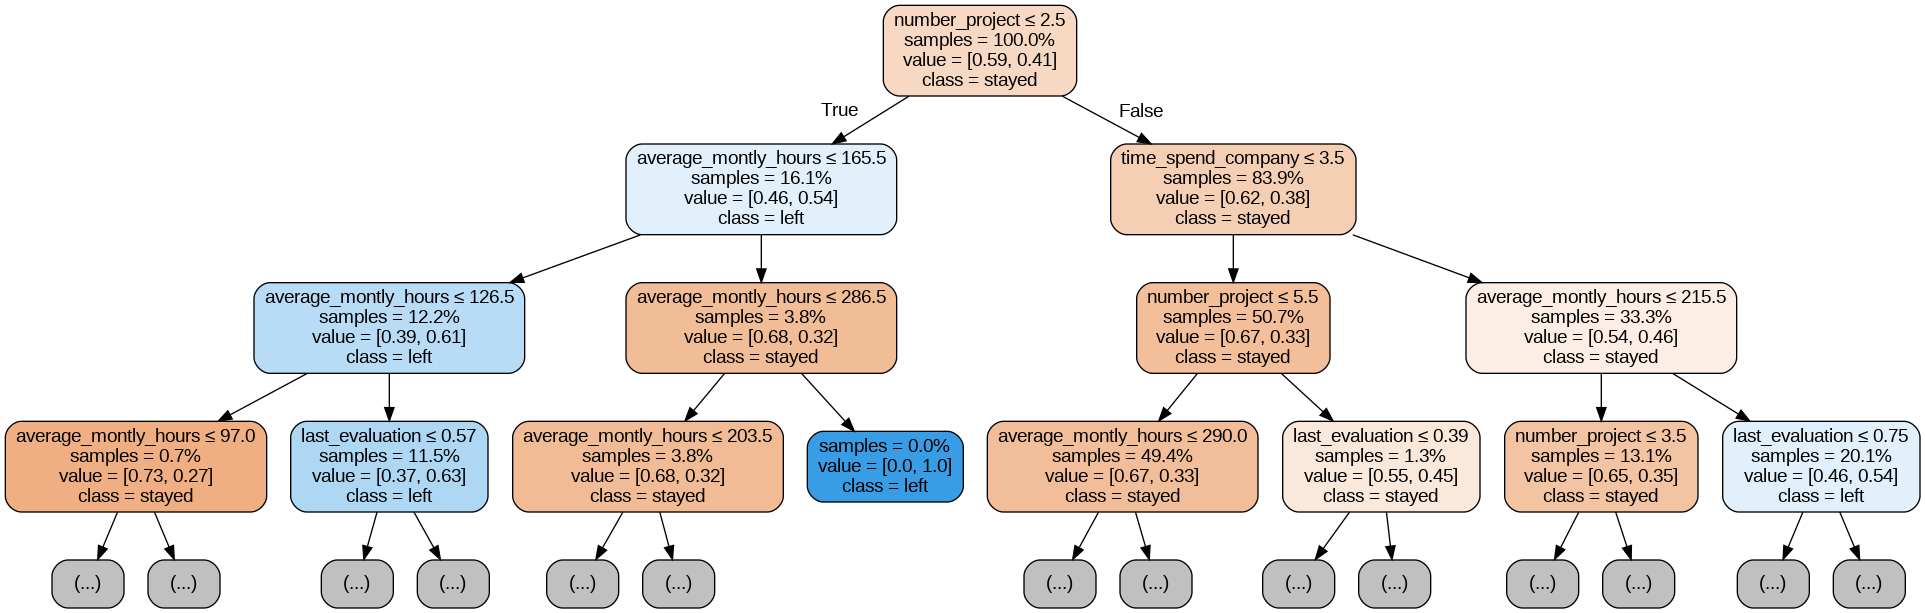

In [ ]:
plot_noised_tree(3000)

##### Устойчивость при обучении на различных выборках при бутстрепе

In [ ]:
def plot_sampled_tree(seed):
    random_gen = np.random.RandomState(seed)
    indices = random_gen.choice(len(train_data), size=len(train_data), replace=True)
    model.fit(
        np.array(train_data)[indices],
        np.array(train_target)[indices]
    )
    return plot_tree(model, "first_tree.out", max_depth=3)

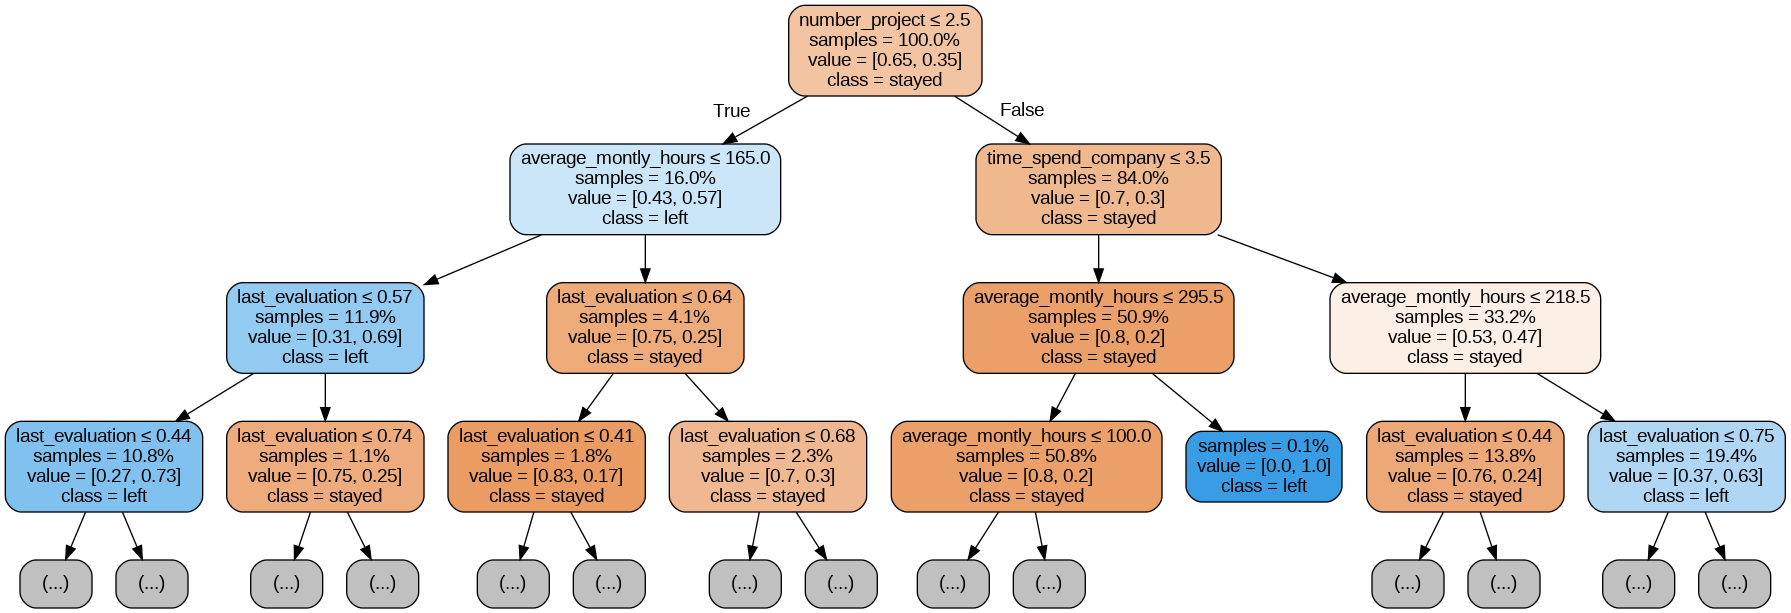

In [ ]:
plot_sampled_tree(42)

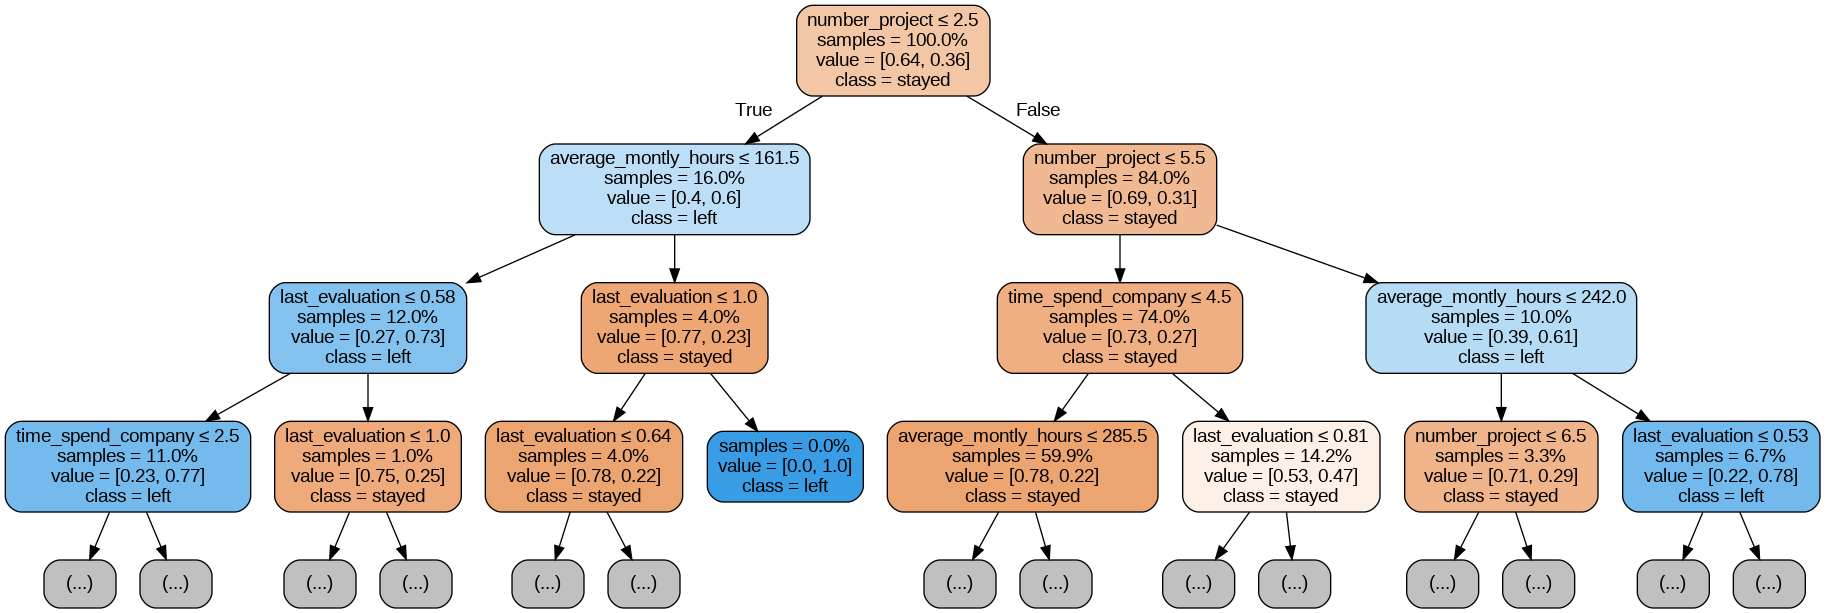

In [ ]:
plot_sampled_tree(777)

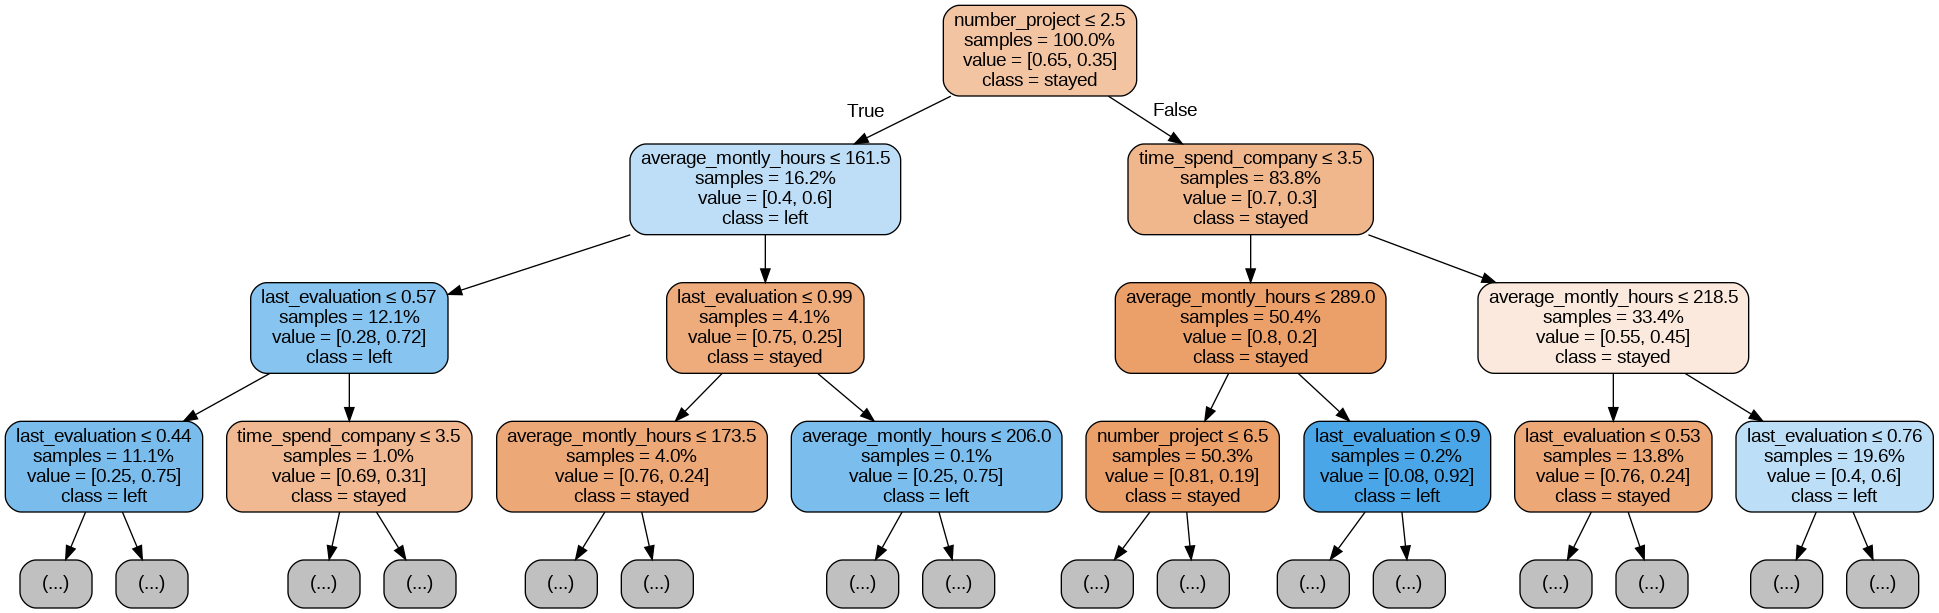

In [ ]:
plot_sampled_tree(666)

# 2. Бэггинг над решающими деревьями <a name="section2"></a>

В этом блокноте мы увидим на примере, насколько позволяет улучшить качество по сравнению с одиночным деревом использование бэггинга и добавление в деревьях рандомизации при выборе признаков для разбиений.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression # для сравнения с линейной моделью

In [ ]:
!wget https://raw.githubusercontent.com/data-mining-in-action/DMIA_Base_2019_Spring/master/seminar0405/HR.csv

--2024-08-02 09:07:05--  https://raw.githubusercontent.com/data-mining-in-action/DMIA_Base_2019_Spring/master/seminar0405/HR.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 283562 (277K) [text/plain]
Saving to: ‘HR.csv’

HR.csv              100%[===================>] 276.92K  --.-KB/s    in 0.04s   

2024-08-02 09:07:05 (6.41 MB/s) - ‘HR.csv’ saved [283562/283562]



In [ ]:
data = pd.read_csv('HR.csv')

target = 'left'
features = [c for c in data if c != target]
print(features)

X, y = data[features], data[target]

['last_evaluation', 'number_project', 'average_montly_hours', 'time_spend_company', 'Work_accident', 'promotion_last_5years']


In [ ]:
d3 = DecisionTreeClassifier() # Обычное решающее дерево

Качество дерева на кросс-валидации

In [ ]:
print("Decision tree:", cross_val_score(d3, X, y).mean())

Decision tree: 0.6621093920195621


Бэггинг над решающими деревьями:

In [ ]:
print("D3 Bagging:",  cross_val_score(BaggingClassifier(d3, random_state=42), X, y).mean())

D3 Bagging: 0.7214464599310882


Усредненная модель оказалась заметно лучше. У решающих деревьев есть существенный недостаток - нестабильность получаемого дерева при небольших изменениях в выборке. Но бэггинг обращает этот недостаток в достоинство, ведь усредненная модель работает лучше, когда базовые модели слабо скоррелированы (это обстоятельство будет пояснено дополнительно ниже - в теоретической части).
Изучив параметры DecisionTreeClassifier, можно найти хороший способ сделать деревья еще более различными - при построении каждого узла отбирать случайные max_features признаков и искать информативное разбиение только по одному из них.

In [ ]:
# Решающее дерево с рандомизацией в сплитах
rnd_d3 = DecisionTreeClassifier(max_features=int(len(features) ** 0.5))

In [ ]:
?DecisionTreeClassifier

In [ ]:
print("Randomized D3 Bagging:", cross_val_score(BaggingClassifier(rnd_d3, random_state=42), X, y).mean())

Randomized D3 Bagging: 0.7235125708569524


В среднем, качество получается еще лучше. Для выбора числа признаков использовалась часто применяемая на практике эвристика - брать корень из общего числа признаков. Если бы мы решали задачу регрессии - брали бы треть от общего числа.

In [ ]:
print("Random Forest:", cross_val_score(RandomForestClassifier(random_state=42), X, y).mean())

Random Forest: 0.7247786595531844


Кстати, давайте посмотрим, нужно ли выбирать случайные признаки в каждом сплите или достаточно выбрать их один раз для каждого дерева. В этом нам поможет параметр max_features в BaggingClassifier:

In [ ]:
?BaggingClassifier

In [ ]:
print("D3 bagging:", cross_val_score(BaggingClassifier(d3, random_state=42, max_features=int(len(features) ** 0.5)), X, y).mean())

D3 bagging: 0.7417161053684561


In [ ]:
print("Logistic Regression:", cross_val_score(LogisticRegression(), X, y).mean())

Logistic Regression: 0.6318360786928976


**Немного теории: почему усреднение увеличивает "устойчивость" модели**



correlation = cov / (sigma1 * sigma2)




cov = ro * sigma^2


____





Пусть есть случайные одинаково распределённые величины $\xi_1, \xi_2, \dots, \xi_n$, скоррелированные с коэффициентом корреляции $\rho$ и дисперсией $\sigma^2$. Какова будет дисперсия величины $\frac1n \sum_{i=1}^n \xi_i$?

Вспомним сначала как связаны ковариация и линейная корреляция:

$$
\mathbf{cov(x, y)} = \frac{\sum{(x_i - \bar{x})}\sum{(y_i - \bar{y})}}{N-1}
$$

$$
\mathbf{corr(x, y)} = \frac{\mathbf{cov(x,y)}}{\sigma_x \sigma_y} => \mathbf{cov(x,y)} = \mathbf{corr(x, y)} \sigma_x \sigma_y
$$

$$\mathbf{D} \frac1n \sum_{i=1}^n \xi_i = \frac1{n^2}\mathbf{cov} (\sum_{i=1}^n \xi_i, \sum_{i=1}^n \xi_i) = \frac1{n^2} \sum_{i=1, j=1}^n \mathbf{cov}(\xi_i, \xi_j)
$$

Разобьем эту сумму на два слагаемых -- когда $i = j$ и когда не равны:

$$
= \frac1{n^2} \sum_{i=1}^n \mathbf{cov}(\xi_i, \xi_i) + \frac1{n^2} \sum_{i=1, j=1, i\neq j}^n \mathbf{cov}(\xi_i, \xi_j)
$$

Рассмотрим первогое слагаемое:
$$
\frac1{n^2} \sum_{i=1}^n \mathbf{cov}(\xi_i, \xi_i)
$$
Чему равна $\mathbf{cov}(\xi_i, \xi_i)$?

$$
\mathbf{cov}(\xi_i, \xi_i) =\frac{\sum_{j = 1}^n(\xi_i^j - \bar{\xi_i})\sum_{j = 1}^n(\xi_i^j - \bar{\xi_i})}{N-1}
$$
То есть $\mathbf{cov}(\xi_i, \xi_i) = D(\xi_i) = \sigma^2$ так как по условию  у всех $\xi_i$ дисперсия одинакова и равна $\sigma^2$

Итого, первое слагаемое:

$$
\frac1{n^2} \sum_{i=1}^n \mathbf{cov}(\xi_i, \xi_i) = \frac1{n^2} \sum_{i=1}^n \sigma^2 = \frac1{n^2} n \sigma^2 = \frac1{n} \sigma^2
$$

Теперь расмотрим второе слагаемое формулы, когда $i \neq j$, используем формулу связи ковариации и корреляции, и тот факт коррелляция между любыми разными $\xi_i$ и $\xi_j$ равна по условию $\rho$:

$$
\frac1{n^2} \sum_{i=1, j=1, i\neq j}^n \mathbf{cov}(\xi_i, \xi_j) = \frac1{n^2} \sum_{i=1, j=1, i\neq j}^n \mathbf{corr(\xi_i, \xi_j)} \sigma_{\xi_i} \sigma_{\xi_j} = \frac1{n^2} \sum_{i=1, j=1, i\neq j}^n \rho \sigma^2
$$

Сколько таких комбинаций? Все возможные ($n^2$) за вычетом случая когда $i = j$ (таких ровно $n$)

Итого, второе слагаемое:

$$
\frac1{n^2} \sum_{i=1, j=1, i\neq j}^n \mathbf{cov}(\xi_i, \xi_j) = \frac1{n^2}(n^2 - n) \rho \sigma^2 = \frac1{n} (n-1) \rho \sigma^2
$$

Подставляя оба слагаемых в исходную формулу получим:

$$
\mathbf{D} \frac1n \sum_{i=1}^n \xi_i  = \frac1{n} \sigma^2 + \frac1{n} (n-1) \rho \sigma^2  = \frac{\sigma^2( 1 + \rho(n-1))}{n}
$$


Таким образом, чем менее величины скоррелированы между собой, тем меньше будет дисперсия после их усреднения. В этом и состоит усреднения прогнозов моделей: давайте сделаем много моделей, желательно с не очень большой корреляцией ответов, а потом усредим их прогнозы, тогда предсказание станет более устойчивым, чем у отдельных моделей.

### Всегда ли RF лучше единичного дерева?

In [ ]:
from sklearn.datasets import make_classification
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)
n_features = 500
n_samples = 2000
data = make_classification(n_samples = n_samples, n_features =n_features, random_state = 42, n_redundant = n_features - n_features // 4)
df = pd.DataFrame(data[0], columns = [f'feature_{k}' for k in range(n_features)])
df['target'] = data[1]
df['feature_1'] = df['target'] + 0.5* df['feature_1']
df.rename(columns={'feature_1':'killer'}, inplace = True)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df.drop('target', axis = 1), df['target'], test_size=0.33, random_state=42)
rf = RandomForestClassifier(random_state = 42)
rf.fit(x_train, y_train,)
print(rf.score(x_test, y_test))

0.95


In [ ]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state=42)
dtc.fit(x_train, y_train)
print(f'{dtc.score(x_test, y_test):0.2f}')

0.99


Почему единичное дерево лучше работает?

In [ ]:
sorted([[col, round(imp, 4)] for imp, col in zip(rf.feature_importances_, \
                                       df.drop('target', axis = 1).columns)], key = lambda x :x[1], reverse=True)[0:5]

[['killer', 0.0949],
 ['feature_197', 0.0273],
 ['feature_324', 0.0273],
 ['feature_182', 0.0268],
 ['feature_437', 0.0261]]

In [ ]:
sorted([[col, round(imp, 4)] for imp, col in zip(dtc.feature_importances_, \
                                       df.drop('target', axis = 1).columns)], key = lambda x :x[1], reverse=True)[0:5]

[['killer', 0.9211],
 ['feature_360', 0.0526],
 ['feature_86', 0.0096],
 ['feature_87', 0.0079],
 ['feature_370', 0.003]]


Почему так? RF стоит на трех китах:



*   subsampling (выкидываем часть точек при построении очередного дерева),
*   subspacing (выкидываем часть фичей при построении очередного дерева),
*  voting (осредняем предикты всех деревьев)

Ситуации когда хорошая фича или важная группа сэмплов падает жертвой bagging / undersampling etc -- более чем частая

# 3. Бустинг над решающими деревьями <a name="section3"></a>

Бустинг это метод построения компизиции алгоритмов, в котором базовые алгоритмы строятся последовательно один за другим, причем каждый следующий алгоритм строится таким образом, чтобы уменьшить ошибку предыдущего.

Положим, что алгоритм это сумма некоторых базовых алгоритмов:
$$
a_N(x) = \sum_{n=1}^N b_n(x)
$$

Пусть задана некоторая функция потерь, которую мы оптимизируем
$$\sum_{i=1}^l L(\hat{y_i}, y_i) \rightarrow min$$



Зададимся вопросом: а что если мы хотим добавить ещё один алгоритм в эту композицию, но не просто добавить, а как можно оптимальнее с точки зрения исходной оптимизационной задачи. То есть уже есть какой-то алгоритм $a_N(x)$ и мы хотим прибавить к нему базовый алгоритм $b_{N+1}(x)$:

$$\sum_{i=1}^l L(a_{N}(x_i) + b_{N+1}(x_i), y_i) \to \min_{b_{N+1}}$$

Сначала имеет смысл решить более простую задачу: определить, какие значения $r_1 ,r_2 ..., r_l$ должен принимать алгоритм $b_N(x_i) = r_i$ на объектах обучающей выборки, чтобы ошибка на обучающей выборке была минимальной:

$$F(r) = \sum_{i=1}^l L(a_{N}(x_i) + r_i, y_i) \to \min_{r},$$

где $r = (r_1, r_2, \dots, r_l)$ - вектор сдвигов.

Поскольку направление наискорейшего убывания функции задается направлением антиградиента, его можно принять в качестве вектора $r$:     

$$
r = -\nabla F \\
$$

$$r_i = \frac{\partial{L}(a_N(x_i), y_i))}{\partial{a_N(x_i)}}, \ \ \ i = \overline{1,l}$$

Таким образом, можно подобрать неплохое улучшение текущего алгоритма $a_N(x)$, а потом ещё раз и ещё, в итоге получив комбинацию алгоритмов, которая будет минимизировать исходный функционал.

Если говорить более точно, в градиентном бустинге итоговый алгоритм строится не просто как сумма базовых алгоритмов, а как взвешенная сумма:
    $$a_N(x) = \sum_{n=1}^N \alpha_n b_n(x)$$
    
Статегии подбора весов $\alpha_n$ тоже могут быть разными по аналогии с подбором шага в градиентном спуске.

## Напишем свой градиентный бустинг

За базу возьмем серию статей на [habr](https://habr.com/ru/companies/vk/articles/438562/)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook
from sklearn import datasets
from sklearn.metrics import mean_squared_error as mse
from sklearn.tree import DecisionTreeRegressor
import itertools
%matplotlib inline

In [ ]:
class GradientBoosting():
    def __init__(self
                 , n_estimators=100
                 , learning_rate=0.1
                 , max_depth=3
                 , random_state=42
                 , criterion='squared_error'
                 , splitter='best'
                 , col_sample = None):

        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.initialization = lambda y: np.mean(y) * np.ones([y.shape[0]])
        self.loss_by_iter = []
        self.trees_ = []
        self.loss_by_iter_test = []
        self.criterion = criterion
        self.splitter = splitter
        self.max_features = col_sample



    def fit(self, X, y):
        self.X = X
        self.y = y
        b = self.initialization(y)

        prediction = b.copy()

        for t in tqdm_notebook(range(self.n_estimators)):

            if t == 0:
                resid = y
            else:
                # антиградиент
                resid = (y - prediction)

            tree = DecisionTreeRegressor(max_depth=self.max_depth
                                          , max_features = self.max_features)


            tree.fit(X, resid)

            # делаем предикт и добавляем алгоритм к ансамблю
            b = tree.predict(X).reshape([X.shape[0]])
            self.trees_.append(tree)
            prediction += self.learning_rate * b
            # добавляем только если не первая итерация
            if t > 0:
                self.loss_by_iter.append(mse(y,prediction))

        return self

    def predict(self, X):

        # сначала прогноз – это просто вектор из средних значений ответов на обучении
        pred = np.ones([X.shape[0]]) * np.mean(self.y)
        # добавляем прогнозы деревьев
        for t in range(self.n_estimators):
            pred += self.learning_rate * self.trees_[t].predict(X).reshape([X.shape[0]])

        return pred



Построим теперь кривую лосса на обучающей выборке, чтобы убедиться, что при каждой итерации у нас действительно происходит его уменьшение.

In [ ]:
!wget https://raw.githubusercontent.com/data-mining-in-action/DMIA_Base_2019_Spring/master/seminar0405/HR.csv

--2024-07-20 16:39:38--  https://raw.githubusercontent.com/data-mining-in-action/DMIA_Base_2019_Spring/master/seminar0405/HR.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 283562 (277K) [text/plain]
Saving to: ‘HR.csv.2’

HR.csv.2            100%[===================>] 276.92K  --.-KB/s    in 0.1s    

2024-07-20 16:39:38 (2.03 MB/s) - ‘HR.csv.2’ saved [283562/283562]



In [ ]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
n_samples = 10000
n_features = 20
data = make_regression(n_samples=n_samples, n_features=n_features, random_state=42, noise=50)
df = pd.DataFrame(data[0], columns=[f'feature_{k}' for k in range(n_features)])
df['target'] = data[1]
x_train, x_test, y_train, y_test = train_test_split(df.drop('target', axis = 1), df['target'], test_size=0.33, random_state=42)

  0%|          | 0/50 [00:00<?, ?it/s]

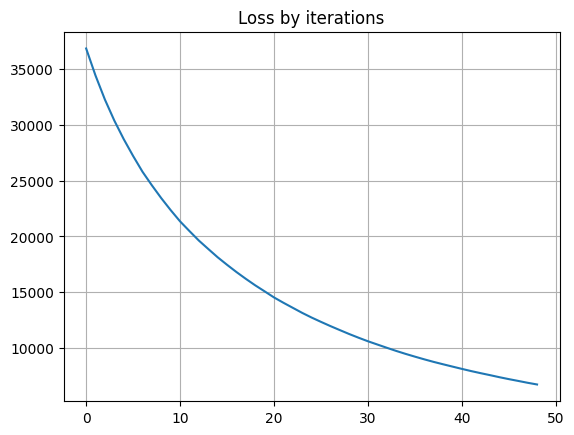

In [ ]:
GDB = GradientBoosting(n_estimators=50)
GDB.fit(x_train, y_train)
x = GDB.predict(x_train)
plt.grid()
plt.title('Loss by iterations')
plt.plot(GDB.loss_by_iter)

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error

In [ ]:
mean_absolute_percentage_error(y_test, GDB.predict(x_test))

1.2884353678375726

Сравним с настоящим, еще и экстремальным

In [ ]:
from xgboost import XGBRegressor
xgb = XGBRegressor(n_estimators=50, max_depth=3, verbosity=0)
xgb.fit(x_train, y_train)
mean_absolute_percentage_error(y_test, xgb.predict(x_test))

1.4211693793650093

Приятно, однако

# 4. Бустинг vs RandomForest <a name="section4"></a>

In [ ]:
!pip install catboost -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 5.4 MB/s eta 0:00:00


In [ ]:
from sklearn import ensemble , model_selection, metrics
from sklearn.model_selection import learning_curve

import numpy as np
import pandas as pd
import xgboost as xgb
import catboost
import lightgbm as lgbm

import warnings
warnings.filterwarnings('ignore')

In [ ]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Данные

Задача на kaggle: https://www.kaggle.com/c/bioresponse

Данные: https://www.kaggle.com/c/bioresponse/data

По данным характеристикам молекулы требуется определить, будет ли дан биологический ответ (biological response).

Признаки нормализованы.

Для демонстрации используется обучающая выборка из исходных данных train.csv, файл с данными прилагается.

In [ ]:
!wget https://raw.githubusercontent.com/data-mining-in-action/DMIA_Base_2019_Spring/master/seminar01/bioresponse.csv

--2024-07-20 15:46:58--  https://raw.githubusercontent.com/data-mining-in-action/DMIA_Base_2019_Spring/master/seminar01/bioresponse.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18623278 (18M) [text/plain]
Saving to: ‘bioresponse.csv’

bioresponse.csv     100%[===================>]  17.76M  42.1MB/s    in 0.4s    

2024-07-20 15:47:00 (42.1 MB/s) - ‘bioresponse.csv’ saved [18623278/18623278]



In [ ]:
bioresponce = pd.read_csv('bioresponse.csv', header=0, sep=',')
bioresponce.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
bioresponce_target = bioresponce.Activity.values
bioresponce_data = bioresponce.iloc[:, 1:]

## Зависимость качества от количества деревьев

In [ ]:
n_trees = [1] + list(range(5, 55, 5))

In [ ]:
%%time
scoring = []
for n_tree in n_trees:
    estimator = ensemble.RandomForestClassifier(n_estimators = n_tree, min_samples_split=5, random_state=1)
    score = model_selection.cross_val_score(
        estimator, bioresponce_data, bioresponce_target,
        scoring = 'accuracy', cv = 3
    )
    scoring.append(score)
scoring = np.asmatrix(scoring)

CPU times: user 15.7 s, sys: 1.06 s, total: 16.7 s
Wall time: 16.7 s


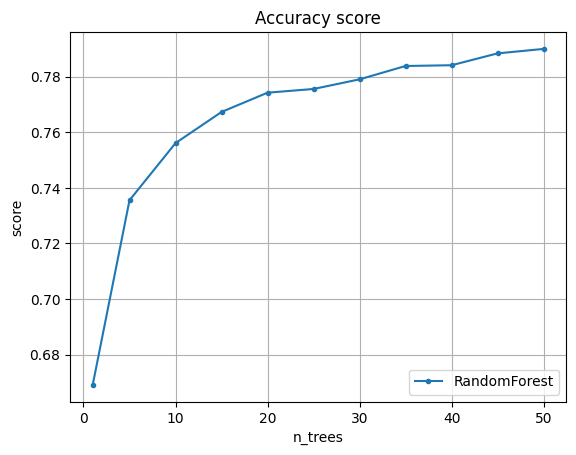

In [ ]:
pylab.plot(n_trees, scoring.mean(axis = 1), marker='.', label='RandomForest')
pylab.grid(True)
pylab.xlabel('n_trees')
pylab.ylabel('score')
pylab.title('Accuracy score')
pylab.legend(loc='lower right');

### XGBoost

In [ ]:
%%time
xgb_scoring = []
for n_tree in n_trees:
    estimator = xgb.XGBClassifier(learning_rate=0.1, max_depth=6, n_estimators=n_tree)
    score = model_selection.cross_val_score(
        estimator, bioresponce_data, bioresponce_target,
        scoring = 'accuracy', cv = 3
    )
    xgb_scoring.append(score)
xgb_scoring = np.asmatrix(xgb_scoring)

CPU times: user 2min 16s, sys: 1.14 s, total: 2min 17s
Wall time: 1min 25s


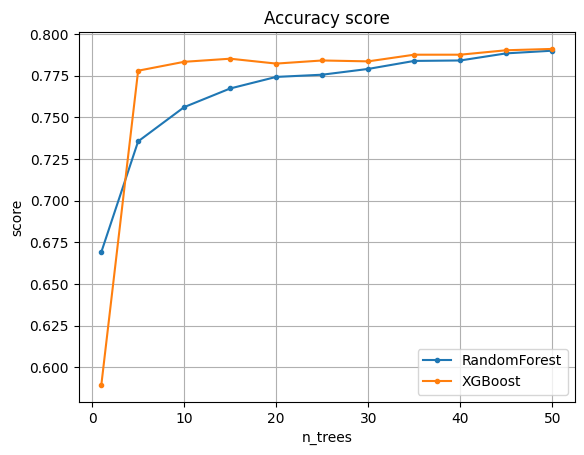

In [ ]:
pylab.plot(n_trees, scoring.mean(axis = 1), marker='.', label='RandomForest')
pylab.plot(n_trees, xgb_scoring.mean(axis = 1), marker='.', label='XGBoost')
pylab.grid(True)
pylab.xlabel('n_trees')
pylab.ylabel('score')
pylab.title('Accuracy score')
pylab.legend(loc='lower right')

 **Материалы по xgboost:**    
python api: http://xgboost.readthedocs.org/en/latest/python/python_api.html

### Catboost

In [ ]:
%%time
catboost_scoring = []
for n_tree in n_trees:
    estimator = catboost.CatBoostClassifier(max_depth=6, n_estimators=n_tree, verbose=False)
    score = model_selection.cross_val_score(
        estimator, bioresponce_data, bioresponce_target,
        scoring = 'accuracy', cv=3
    )
    catboost_scoring.append(score)
catboost_scoring = np.asmatrix(catboost_scoring)

CPU times: user 2min 9s, sys: 2.74 s, total: 2min 12s
Wall time: 1min 27s


**Материалы по Catboost:**     
python api: https://tech.yandex.com/catboost/doc/dg/concepts/python-quickstart-docpage/

### LightGMB

In [ ]:
import os, contextlib

In [ ]:
%%time
lgbm_scoring = []
for n_tree in n_trees:
  with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
    estimator = lgbm.LGBMClassifier(learning_rate=0.5, max_depth=6, n_estimators=n_tree, num_leaves = 20)
    score = model_selection.cross_val_score(
        estimator, bioresponce_data, bioresponce_target,
        scoring='accuracy', cv=3
    )
    lgbm_scoring.append(score)
lgbm_scoring = np.asmatrix(lgbm_scoring)

CPU times: user 25 s, sys: 90.7 ms, total: 25.1 s
Wall time: 25.4 s


**Материалы по LightGMB:**      
https://lightgbm.readthedocs.io/en/latest/Python-API.html#scikit-learn-api

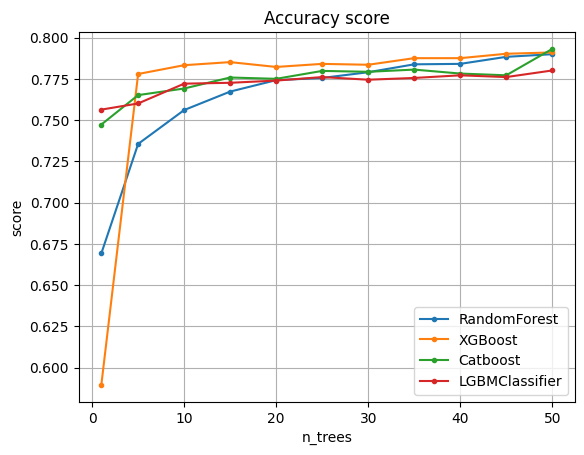

In [ ]:
pylab.plot(n_trees, scoring.mean(axis=1), marker='.', label='RandomForest')
pylab.plot(n_trees, xgb_scoring.mean(axis=1), marker='.', label='XGBoost')
pylab.plot(n_trees, catboost_scoring.mean(axis=1), marker='.', label='Catboost')
pylab.plot(n_trees, lgbm_scoring.mean(axis=1), marker='.', label='LGBMClassifier')
pylab.grid(True)
pylab.xlabel('n_trees')
pylab.ylabel('score')
pylab.title('Accuracy score')
pylab.legend(loc='lower right');

# 5. Bias-variance trade off на практике <a name="section5"></a>

Мы не будем выписывать строгие формулы, но попробуем объяснить идею этих понятий.

Пусть у нас есть алгоритм обучения, который по данным может создать модель.

Ошибка этих моделей может быть разложена на три части:
* **Noise** – шум данных, не предсказуем, теоретический минимум ошибки
* **Bias** – смещение, на сколько хорошо работает средний алгоритм. Средний алгоритм это "возьмём случайные данные, обучим алгоритм, сделаем предсказания", **Bias** – это ошибка средних предсказаний.
* **Variance** – разброс, на сколько устойчиво работает алгоритм. Опять же "возьмём случайные данные, обучим алгоритм, сделаем предсказания", **Variance** – это разрос этих предсказаний.

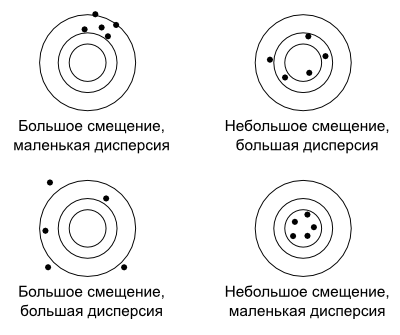


Как вы думаете на какую составляющую Бустинг и Бэггинг влияют, а на какую нет?

In [ ]:
!pip install catboost -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 6.3 MB/s eta 0:00:00


In [ ]:
!pip install dask -q

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm.sklearn import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
import os, contextlib
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

In [ ]:
!wget https://raw.githubusercontent.com/Shreyas3108/house-price-prediction/master/kc_house_data.csv

--2024-08-23 08:51:10--  https://raw.githubusercontent.com/Shreyas3108/house-price-prediction/master/kc_house_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2515206 (2.4M) [text/plain]
Saving to: ‘kc_house_data.csv’

kc_house_data.csv   100%[===================>]   2.40M  --.-KB/s    in 0.03s   

2024-08-23 08:51:10 (89.5 MB/s) - ‘kc_house_data.csv’ saved [2515206/2515206]



In [ ]:
data = pd.read_csv('kc_house_data.csv')
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [ ]:
data['date'] = pd.to_datetime(data['date']).dt.year
data['is_renovated'] = data['yr_renovated'] > 0
data['age'] = data['date'] - data['yr_built']
features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view',
            'grade', 'sqft_above', 'sqft_living15',	'sqft_lot15', 'age', 'condition']


In [ ]:
y = data['price'].values
X = data[features].values


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
def sample_model(seed, model):
  with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
    random_gen = np.random.RandomState(seed)
    indices = random_gen.choice(len(y_train), size=len(y_train), replace=True)
    model.fit(X_train[indices, :], y_train[indices])
  return model

def estimate_bias_variance(model, name = '', iters_count=100):
    y_preds = []
    for seed in range(iters_count):
        model = sample_model(seed, model)
        y_preds.append(model.predict(X_test))
    y_preds = np.array(y_preds)

    bias = np.sqrt(np.mean((y_preds.mean(axis=0) - y_test) ** 2))
    variance = np.mean((y_preds.mean(axis=0) - y_preds) ** 2)

    print(f'{name}, Bias: {bias}, Variance:{variance}')
    return bias, variance, name

In [ ]:
results = []
results.append(estimate_bias_variance(LinearRegression(), 'LinReg'))
results.append(estimate_bias_variance(DecisionTreeRegressor(max_depth=5), 'DT_5d'))
results.append(estimate_bias_variance(DecisionTreeRegressor(max_depth=10), 'DT_10d'))
results.append(estimate_bias_variance(DecisionTreeRegressor(max_depth=15), 'DT_15d'))
results.append(estimate_bias_variance(DecisionTreeRegressor(max_depth=None), 'DT_бездонное =)'))
results.append(estimate_bias_variance(RandomForestRegressor(n_estimators=10, random_state=42), 'RF_10est'))
results.append(estimate_bias_variance(RandomForestRegressor(n_estimators=50, random_state=42), 'RF_50est'))
results.append(estimate_bias_variance(XGBRegressor(n_estimators=1, max_depth=20, verbosity=0), 'XGB_1est_20d'))
results.append(estimate_bias_variance(XGBRegressor(n_estimators=1, max_depth=10, verbosity=0), 'XGB_1est_10d'))
results.append(estimate_bias_variance(XGBRegressor(n_estimators=1, max_depth=5, verbosity=0), 'XGB_1est_5d'))
results.append(estimate_bias_variance(XGBRegressor(n_estimators=10, max_depth=5, verbosity=0), 'XGB_10est_5d'))
results.append(estimate_bias_variance(XGBRegressor(n_estimators=100, max_depth=5, verbosity=0), 'XGB_100est_5d'))
results.append(estimate_bias_variance(CatBoostRegressor(n_estimators=1, max_depth=6, verbose=False), 'CatB_1est_5d'))
results.append(estimate_bias_variance(CatBoostRegressor(n_estimators=10, max_depth=6, verbose=False), 'CatB_10est_5d'))
results.append(estimate_bias_variance(CatBoostRegressor(n_estimators=100, max_depth=6, verbose=False), 'CatB_100est_5d'))
results.append(estimate_bias_variance(LGBMRegressor(n_estimators=1, max_depth=5, num_leaves = 20), 'LGBM_1est_5d'))
results.append(estimate_bias_variance(LGBMRegressor(n_estimators=10, max_depth=5, num_leaves = 20), 'LGBM_10est_5d'))
results.append(estimate_bias_variance(LGBMRegressor(n_estimators=100, max_depth=5, num_leaves = 20), 'LGBM_100est_5d'))

LinReg, Bias: 215761.16258596673, Variance:145939702.59779236
DT_5d, Bias: 215214.8868469053, Variance:10724394822.071783
DT_10d, Bias: 195825.8164634175, Variance:20546738789.751144
DT_15d, Bias: 193217.80553506187, Variance:30494223187.233807
DT_бездонное =), Bias: 193354.77010733847, Variance:35216081761.49234
RF_10est, Bias: 188917.63257524502, Variance:6324046783.334228
RF_50est, Bias: 189652.17875261183, Variance:3557196560.4070005
XGB_1est_20d, Bias: 297476.7479468987, Variance:2066426752.0
XGB_1est_10d, Bias: 296799.3152195432, Variance:1462251520.0
XGB_1est_5d, Bias: 301101.64464266534, Variance:906024704.0
XGB_10est_5d, Bias: 190336.4834938215, Variance:3223499776.0
XGB_100est_5d, Bias: 182663.8859011181, Variance:5160251392.0
CatB_1est_5d, Bias: 278110.20065445016, Variance:2832287707.1099954
CatB_10est_5d, Bias: 193497.76698970108, Variance:3740856164.337262
CatB_100est_5d, Bias: 182430.90580265754, Variance:4557575162.583848
LGBM_1est_5d, Bias: 344944.58010127017, Variance

In [ ]:
df = pd.DataFrame(data = results, columns = ['Bias', 'Variance', 'Model'])

In [ ]:
import plotly.graph_objs as go
fig = go.Figure()

fig.add_trace(go.Scatter(x=df['Bias'], y=df['Variance'], mode='text+markers', text = df['Model'].values
              , marker=dict(color='LightSkyBlue', size=10, line=dict(color='MediumPurple', width=2))
              , textposition='top right'
                        )
              )

fig.update_layout(
                  xaxis_title="Bias"
                  , yaxis_title="Variance"
                  , title="Bias-variance crossplot"
                  , height=900
                  , width=1200
                  , font_family="Arial"
                  , font_color="black"
                  , font_size = 16
                  , title_font_family="Times New Roman"
                  , title_font_size = 18
                  , title_font_color="black"
                  , separators=", .*"
)

fig.show()